Intravoxel incoherent motion
===============================================================

The intra­voxel incoherent motion (IVIM) model describes diffusion and perfusion in the signal acquired with diffusion. The IVIM model can be understood as an adaptation of Stejskal’s and Tanner’s work (ref) on biologic tissue, and was proposed by Le Bihan et al (ref). The hypothesis is that two compartments exist: a slow moving compartment, where particles diffuse in a Brownian fashion as a consequence of thermal energy, and a fast moving compartment (the vascular compartment), where blood moves as a consequence of pressure gradient. In this second compartment, a pseudo-diffusion term (D\*) is introduced that describes on a macroscopic level the displacement of the blood elements in an assumed randomly laid vascular network. For the perfusion to have a physiologic meaning, one expects that D\* is greater than D.

The IVIM model expresses the diffusion signal as follows :

.. math::

    S(b)=S_{0}[fe^{-b D*} + (1 - f)e^{-b D}]

where $\mathbf{b}$ is the gradient value (which is dependent on the measurement parameters), $S_0$ is the signal in the absence of diffusion gradient sensitization, $\mathbf{f}$ is the perfusion fraction, $\mathbf{D}$ is the diffusion coefficient, $\mathbf{D*}$ is the pseudo diffusion constant. 

In the following example we show how to fit the IVIM model on diffusion-weighted dataset and visualize the perfusion and diffusion. First, we import all relevant modules:

In [97]:
import numpy as np
from scipy.optimize import leastsq
import matplotlib.pyplot as plt

from dipy.reconst.ivim import IvimModel, _ivim_error, ivim_function
from dipy.data.fetcher import read_ivim

% matplotlib inline

We get an IVIM dataset using dipy's data fetcher read_ivim. The image data is an acquired IVIM dataset with 21 b-values acquired in 3 directions, registered to each other and the directions were averaged into one. So, this dataset is 4D where the 4th dimension is the b-values. The fetcher read_ivim gets the .nii, .bval and .bvec files.

In [2]:
img, gtab = read_ivim()

Dataset is already in place. If you want to fetch it again please first remove the folder /root/.dipy/ivim 


img contains a nibabel Nifti1Image object (with the data) and gtab contains a
GradientTable object (information about the gradients e.g. b-values and
b-vectors). We get the data from img using read_data.

In [72]:
data = img.get_data()
print('data.shape (%d, %d, %d, %d)' % data.shape)

data.shape (256, 256, 54, 21)


Thus the data is a 256x256x54 volume and the fourth dimension specifies the bvalue.
Let us visualize the data by taking a slice midway (z = 27) at bvalue=0.

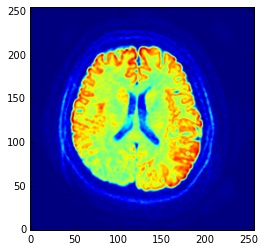

In [73]:
z = 33
b = 20

plt.imshow(data[:,:,z,b].T, origin='lower')
plt.show()

Let us now take a section of the slice for fitting the IVIM model. The image below shows a section containing cerebral spinal fluid (CSF) so it should have a very high f and D\*, the area between the right and left is white matter so that should be lower, and the region on the right is gray matter and CSF. That should give us some contrast to see the values varying across the regions.
![Spinal fluid](https://cloud.githubusercontent.com/assets/1086934/16049003/00a1aad4-320b-11e6-896a-c7e50ed68371.png)

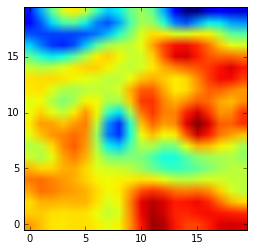

In [76]:
x1, x2 = 160, 180
y1, y2 = 90, 110

plt.imshow(data[x1:x2,y1:y2,z,b].T, origin='lower')
plt.show()

Now that we have prepared the datasets we can go forward with the ivim fit. Instead of fitting the entire volume, we will fit for the slice of data containing CSF. (x1, x2), (y1, y2) and z specify the coordindates of the section.

In [77]:
data_slice = data[x1:x2, y1:y2, z, :]

Now that we have the data we can go forward with the ivim fit.
First, we instantiate the Ivim model in the following way.

In [78]:
ivimmodel = IvimModel(gtab)

Fitting the data is very simple. We just need to call the fit method of the
IvimModel.

In [80]:
ivimfit = ivimmodel.fit(data_slice)

/root/dev/gsoc16/dipy/dipy/reconst/ivim.py:26: RuntimeWarning: overflow encountered in exp
  S = S0 * (f * np.exp(-bvals * D_star) + (1 - f) * np.exp(-bvals * D))
/root/dev/gsoc16/dipy/dipy/reconst/ivim.py:33: RuntimeWarning: overflow encountered in square
  return (signal - ivim_function(params, bvals))**2
/root/dev/gsoc16/dipy/dipy/reconst/ivim.py:26: RuntimeWarning: overflow encountered in multiply
  S = S0 * (f * np.exp(-bvals * D_star) + (1 - f) * np.exp(-bvals * D))
/root/anaconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:421: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


The fit method creates a IvimFit object which contains the fitting parameters of 
the model and can be easily extracted by the model_params attribute. Parameters are packed as an array with the last dimension being 4 which gives the (S0, f, D\*, D) for each voxel.

In [119]:
ivimparams = ivimfit.model_params
print ("ivimparams.shape : {}".format(ivimparams.shape))

ivimparams.shape : (20, 20, 4)


As we see, we have a 20x20 slice at the height z = 33. Thus we have 400 voxels. We will now plot the values of S0, f, D\* and D for some voxels and also the various maps for the entire slice. This will give us an idea about the diffusion and perfusion in the section. Let (i,j) denote the coordinate of the voxel.

In [111]:
i, j = 10, 10
estimated_params = ivimfit.model_params[i, j, :]
print (estimated_params)

[  6.76777588e+03   2.05213734e-01   4.72751938e-03   6.57359895e-04]


Let us define a plotting function. For this we will use the ivim_function defined in the module ivim which takes bvalues and ivim parameters and returns the estimated signal.

In [112]:
def plot_signals(bvals, signal, estimated_params):
    estimated_signal = ivim_function(estimated_params, bvals)
    
    plt.scatter(bvals, signal, color="green", label="Actual signal")
    plt.scatter(bvals, estimated_signal, color="red", label="Estimated Signal")
    plt.xlabel("bvalues")
    plt.ylabel("Signals")
    
    S0_est, f_est, D_star_est, D_est = estimated_params
    text_fit = """Estimated \n S0={:06.3f} f={:06.4f}\n
                D*={:06.5f} D={:06.5f}""".format(S0_est, f_est, D_star_est, D_est)
    
    plt.text(0.65, 0.50, text_fit, horizontalalignment='center',
             verticalalignment='center', transform=plt.gca().transAxes)
    plt.legend(loc='upper left')    
    plt.show()

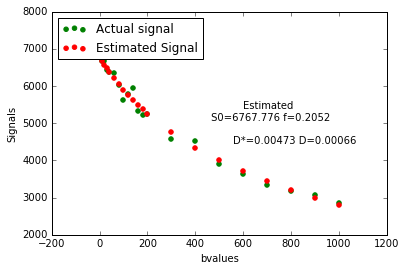

In [113]:
plot_signals(gtab.bvals, data_slice[i,j, :], estimated_params)

Now we can map the perfusion and diffusion maps for the slice. We will plot heatmap showing the values using a colormap. It will be useful to define another plotting function for the heatmap here. We will need to specify the lower and upper limits for our data. For example, the perfusion fractions should be in the range (0,1). Similarly, the diffusion and pseudo-diffusion constants are much smaller than 1. We pass another argument called "variable" to out plotting function which gives the label for the plot.

In [143]:
def plot_map(raw_data, variable, limits):
    lower, upper = limits
    plt.title('Map for {}'.format(variable))
    plt.imshow(raw_data.T, origin='lower', clim=(lower, upper))
    plt.colorbar()
    plt.show()

Let us get the various plots so that we can visualize them in one page

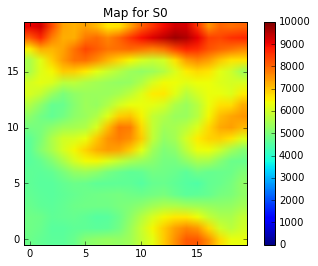

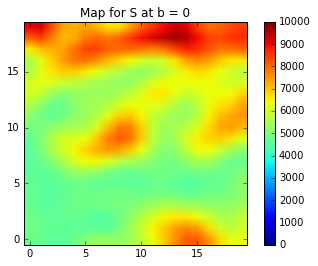

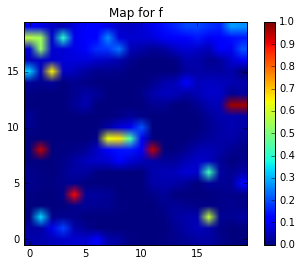

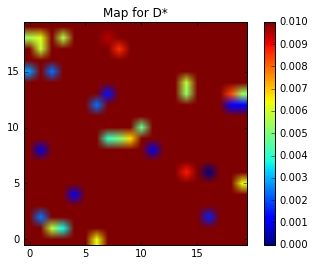

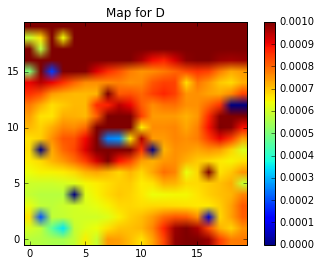

In [153]:
plot_map(ivimparams[:,:, 0], "S0", (0,10000))
plot_map(data_slice[:,:, 0], "S at b = 0", (0,10000))

plot_map(ivimparams[:,:, 1], "f", (0,1))
plot_map(ivimparams[:,:, 2], "D*", (0,0.01))
plot_map(ivimparams[:,:, 3], "D", (0,0.001))